In [2]:
!pip install tenseal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 117.6 MB/s eta 0:00:00


In [3]:
import tenseal as ts
import pandas as pd
import random
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import multiprocessing as mp
from encrypted import encrypt_chunk, evaluate_chunk
from sklearn.datasets import fetch_covtype

# Set random seeds for reproducibility
random.seed(73)
np.random.seed(73)

You can easily input your own dataset into this structure by replacing the `fetch_covtype()` function with your desired data source (e.g., `pd.read_csv(...)` or any other loading method). The first train_test_split is used to reduce the dataset size to a smaller, more manageable subset (in this case, 5% of the original data) while preserving the class distribution through stratified sampling. This is useful when working with large datasets or for quicker experimentation. The second split performs a standard train-test division on the reduced data to separate training and evaluation sets. Finally, the feature matrix X is standardized using `StandardScaler` to ensure that all features have zero mean and unit variance, which is often beneficial for many machine learning algorithms.

In [4]:
# --- Data Loading and Preprocessing (Covertype dataset) ---
covtype = fetch_covtype()
X_full, y_full = covtype.data, covtype.target

# Convert to binary classification: class 1 vs others
y_full = (y_full == 1).astype(int)

# Take 5% of the data with stratified sampling (~30k rows)
X, _, y_np, _ = train_test_split(
    X_full, y_full,
    test_size=0.95,
    stratify=y_full,
    random_state=42
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_np, test_size=0.33, random_state=42
)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("############# Data summary (Breast Cancer Dataset) #############")
print(f"X_train has shape: {X_train.shape}")
print(f"y_train has shape: {y_train.shape}")
print(f"X_test has shape: {X_test.shape}")
print(f"y_test has shape: {y_test.shape}")
print("##############################################################")

############# Data summary (Breast Cancer Dataset) #############
X_train has shape: (19463, 54)
y_train has shape: (19463,)
X_test has shape: (9587, 54)
y_test has shape: (9587,)
##############################################################


In [5]:
# --- Plain Training (scikit-learn) ---
print("\nTraining on plain data...")
lr = LogisticRegression()
t_start = time()
lr.fit(X_train, y_train)
t_end = time()
print(f"Training finished in {t_end - t_start:.2f}s")

# --- Plain Evaluation ---
print("\nEvaluating on plain data...")
y_pred_plain = lr.predict(X_test)
plain_accuracy = np.mean(y_pred_plain == y_test)
print(f"Accuracy on plain test data: {plain_accuracy:.4f}")

# --- Homomorphic Encryption Setup ---
print("\nSetting up homomorphic encryption...")
context = ts.context(ts.SCHEME_TYPE.CKKS, 4096, coeff_mod_bit_sizes=[40, 20, 40])
context.global_scale = 2**20
context.generate_galois_keys()


Training on plain data...
Training finished in 2.06s

Evaluating on plain data...
Accuracy on plain test data: 0.7652

Setting up homomorphic encryption...



----- Running Test 1/3 -----
Running Sequential...
Sequential Time: 116.80s
Sequential Accuracy: 0.6397

Running Parallel...
Parallel Time: 30.69s
Parallel Accuracy: 0.6397

Comparison:
Speedup: 3.8x
Accuracy difference: 0.0000

----- Running Test 2/3 -----
Running Sequential...
Sequential Time: 116.91s
Sequential Accuracy: 0.6397

Running Parallel...
Parallel Time: 31.52s
Parallel Accuracy: 0.6397

Comparison:
Speedup: 3.7x
Accuracy difference: 0.0000

----- Running Test 3/3 -----
Running Sequential...
Sequential Time: 116.62s
Sequential Accuracy: 0.6397

Running Parallel...
Parallel Time: 32.30s
Parallel Accuracy: 0.6397

Comparison:
Speedup: 3.6x
Accuracy difference: 0.0000


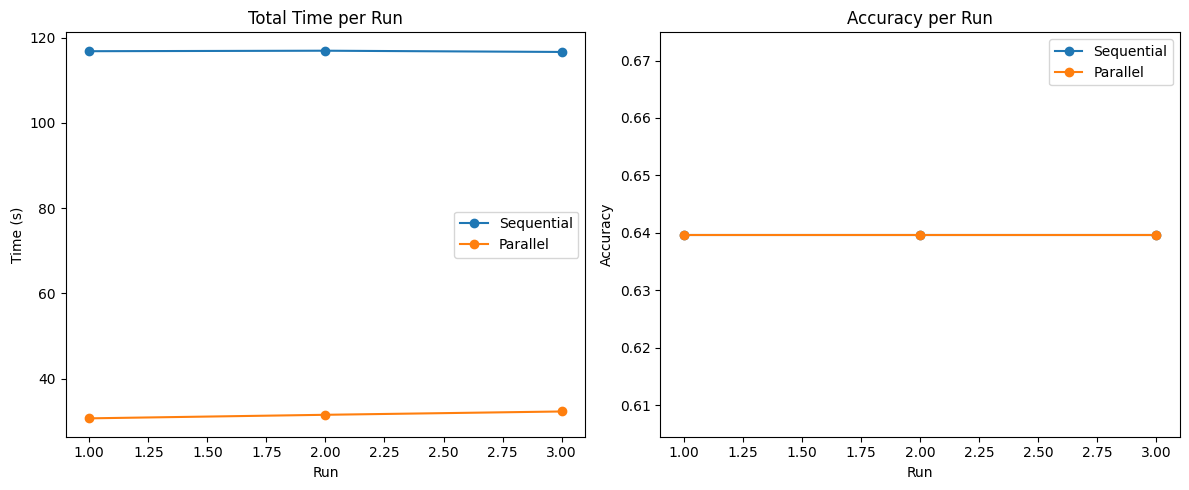

In [6]:
# Extract weights and bias from the trained scikit-learn model
weight = lr.coef_[0]
bias = lr.intercept_[0]

# Serialize context for multiprocessing
ctx_serialized = context.serialize()

# --- Sequential vs. Parallel Comparison ---
num_runs = 3
seq_times, par_times = [], []
seq_accs, par_accs = [], []


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


for i in range(num_runs):
    print(f"\n----- Running Test {i+1}/{num_runs} -----")

    # --- Sequential Execution ---
    print("Running Sequential...")
    t_start_seq = time()

    # 1. Sequential Encryption
    enc_x_test_seq = [ts.ckks_vector(context, x.tolist()) for x in X_test]

    # 2. Sequential Evaluation
    weight_vec = ts.ckks_vector(context, weight)
    bias_vec = ts.ckks_vector(context, [bias])

    decrypted_outputs_seq = []
    for enc_x in enc_x_test_seq:
        out = enc_x.dot(weight_vec) + bias_vec
        decrypted_outputs_seq.append(out.decrypt()[0])

    t_end_seq = time()
    seq_time = t_end_seq - t_start_seq
    seq_times.append(seq_time)

    decrypted_preds_seq = (sigmoid(np.array(decrypted_outputs_seq)) > 0.5).astype(int)
    seq_acc = np.mean(decrypted_preds_seq == y_test)
    seq_accs.append(seq_acc)

    print(f"Sequential Time: {seq_time:.2f}s")
    print(f"Sequential Accuracy: {seq_acc:.4f}")

    # --- Parallel Execution ---
    print("\nRunning Parallel...")
    t_start_par = time()

    # 1. Parallel Encryption
    def parallel_encrypt(data, context_serialized):
        n_proc = mp.cpu_count()
        chunk_size = -(-len(data) // n_proc)
        chunks = [
            (context_serialized, data[i : i + chunk_size])
            for i in range(0, len(data), chunk_size)
        ]
        with mp.Pool(n_proc) as p:
            encrypted_chunks = p.map(encrypt_chunk, chunks)
        return [item for sublist in encrypted_chunks for item in sublist]

    enc_x_test_par = parallel_encrypt(X_test, ctx_serialized)

    # 2. Parallel Evaluation
    def parallel_evaluate(enc_data, y_data, context_serialized, weight, bias):
        n_proc = mp.cpu_count()
        chunk_size = -(-len(enc_data) // n_proc)
        weight_serialized = ts.ckks_vector(context, weight).serialize()
        bias_serialized = ts.ckks_vector(context, [bias]).serialize()
        chunks = [
            (
                context_serialized,
                weight_serialized,
                bias_serialized,
                enc_data[i : i + chunk_size],
                y_data[i : i + chunk_size],
            )
            for i in range(0, len(enc_data), chunk_size)
        ]
        with mp.Pool(n_proc) as p:
            results = p.map(evaluate_chunk, chunks)
        return results

    eval_results_par = parallel_evaluate(
        enc_x_test_par, y_test, ctx_serialized, weight, bias
    )

    decrypted_outputs_par = []
    for outputs_chunk, _ in eval_results_par:
        for out_ser in outputs_chunk:
            out_vec = ts.ckks_vector_from(context, out_ser)
            decrypted_outputs_par.append(out_vec.decrypt()[0])

    t_end_par = time()
    par_time = t_end_par - t_start_par
    par_times.append(par_time)

    decrypted_preds_par = (sigmoid(np.array(decrypted_outputs_par)) > 0.5).astype(int)
    par_acc = np.mean(decrypted_preds_par == y_test)
    par_accs.append(par_acc)

    print(f"Parallel Time: {par_time:.2f}s")
    print(f"Parallel Accuracy: {par_acc:.4f}")

    # 3. Results comparison
    print("\nComparison:")
    print(f"Speedup: {abs(seq_times[-1]/par_times[-1]):.1f}x")
    print(f"Accuracy difference: {abs(seq_acc - par_acc):.4f}")

# --- Plotting ---
runs = np.arange(1, num_runs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(runs, seq_times, marker="o", label="Sequential")
plt.plot(runs, par_times, marker="o", label="Parallel")
plt.title("Total Time per Run")
plt.xlabel("Run")
plt.ylabel("Time (s)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(runs, seq_accs, marker="o", label="Sequential")
plt.plot(runs, par_accs, marker="o", label="Parallel")
plt.title("Accuracy per Run")
plt.xlabel("Run")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def train_model(X_train, y_train):
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    return lr

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def setup_he_context():
    context = ts.context(ts.SCHEME_TYPE.CKKS, 4096, coeff_mod_bit_sizes=[40, 20, 40])
    context.global_scale = 2**20
    context.generate_galois_keys()
    return context

def encrypt_data(X, context):
    return [ts.ckks_vector(context, x.tolist()) for x in X]

def evaluate_encrypted(enc_X, weight, bias, context):
    weight_vec = ts.ckks_vector(context, weight)
    bias_vec = ts.ckks_vector(context, [bias])
    outputs = []
    for enc_x in enc_X:
        out = enc_x.dot(weight_vec) + bias_vec
        outputs.append(out)
    return outputs

def decrypt_outputs(outputs):
    return np.array([out.decrypt()[0] for out in outputs])

def predict_from_logits(logits):
    return (sigmoid(logits) > 0.5).astype(int)

In [7]:
import multiprocessing as mp

def parallel_encrypt(X, context_serialized):
    n_proc = mp.cpu_count()
    chunk_size = -(-len(X) // n_proc)
    chunks = [
        (context_serialized, X[i : i + chunk_size])
        for i in range(0, len(X), chunk_size)
    ]
    with mp.Pool(n_proc) as p:
        encrypted_chunks = p.map(encrypt_chunk, chunks)
    # Flatten the list of lists
    return [item for sublist in encrypted_chunks for item in sublist]

def parallel_evaluate(enc_X, y, context_serialized, weight, bias, context):
    n_proc = mp.cpu_count()
    chunk_size = -(-len(enc_X) // n_proc)
    weight_serialized = ts.ckks_vector(context, weight).serialize()
    bias_serialized = ts.ckks_vector(context, [bias]).serialize()
    chunks = [
        (
            context_serialized,
            weight_serialized,
            bias_serialized,
            enc_X[i : i + chunk_size],
            y[i : i + chunk_size],
        )
        for i in range(0, len(enc_X), chunk_size)
    ]
    with mp.Pool(n_proc) as p:
        results = p.map(evaluate_chunk, chunks)
    # Flatten outputs
    outputs = []
    for outputs_chunk, _ in results:
        outputs.extend(outputs_chunk)
    return outputs

def parallel_decrypt(outputs_serialized, context):
    # outputs_serialized: list of serialized CKKS vectors
    return np.array([
        ts.ckks_vector_from(context, out_ser).decrypt()[0]
        for out_ser in outputs_serialized
    ])

## Pipeline Usage
This pipeline demonstrates privacy-preserving inference using homomorphic encryption (HE) with logistic regression. Below, each step is explained in detail.
1. Train model
- train_model(X_train, y_train): Trains a logistic regression model on your training data and returns the fitted model.
- weight = lr.coef_[0]: Extracts the learned weights (model coefficients) from the trained logistic regression model. These are used for encrypted inference.
- bias = lr.intercept_[0]: Extracts the learned bias (intercept) from the model. 
  
We fit the model to our data and extract the numbers it learned (weights and bias) so we can use them for encrypted predictions.

2.  Set up the encryption context
We create a special encryption context. Think of this as setting up the “rules” for how encryption and computation will work.



In [10]:

# Example pipeline usage:
# 1. Train model
lr = train_model(X_train, y_train)
weight = lr.coef_[0]
bias = lr.intercept_[0]

# 2. Setup HE context
context = setup_he_context()

3. Encrypt new data (e.g., X_test)
Here, we take our test data and encrypt every sample. Now, even if someone sees this data, they can’t read it!

1. Evaluate encrypted data
We run our model on the encrypted data. The data stays encrypted the whole time—no peeking!

1. Decrypt outputs
Now we decrypt the model’s outputs (the “logits”) so we can actually see the results.

1. Predict and evaluate
We turn the decrypted outputs into 0s and 1s (predictions), compare them to the real answers, and print out how accurate we were—even though all the computation happened on encrypted data!

In [ ]:

# 3. Encrypt new data (e.g., X_test)
enc_X_test = encrypt_data(X_test, context)

# 4. Evaluate encrypted data
outputs = evaluate_encrypted(enc_X_test, weight, bias, context)

# 5. Decrypt outputs
logits = decrypt_outputs(outputs)

# 6. Predict and evaluate
preds = predict_from_logits(logits)
acc = np.mean(preds == y_test)
print(f"Encrypted accuracy: {acc:.4f}")


Encrypted accuracy: 0.7555



Parallel (Multiprocessing) Pipeline
When you have a lot of data, doing everything in a single process can be slow. Here, we use Python’s multiprocessing to speed things up by splitting the work across all available CPU cores. Here’s how it works:

1. Serialize the Encryption Context
We need to share the encryption context between processes, so we serialize it:

This just means we’re making the context portable so each process can use it.

2. Parallel Encryption
Instead of encrypting each test sample one by one, we split the data into chunks and encrypt them in parallel. This makes the encryption step much faster when you have a lot of data.

3. Parallel Evaluation
Now, we do the actual model inference (dot product + bias) on the encrypted data, again in parallel. Each process handles a chunk of the encrypted data, using the model’s weights and bias.

4. Parallel Decryption
After evaluation, the results are still encrypted. We decrypt them in parallel, so this step is also much faster for big datasets.

5. Predict and Evaluate
Finally, we turn the decrypted model outputs into binary predictions (0 or 1) and check how accurate they are compared to the true labels.



In [9]:

# Serializacja kontekstu do multiprocessing
ctx_serialized = context.serialize()

# 1. Parallel encryption
enc_X_test_par = parallel_encrypt(X_test, ctx_serialized)

# 2. Parallel evaluation
outputs_serialized = parallel_evaluate(enc_X_test_par, y_test, ctx_serialized, weight, bias, context)

# 3. Parallel decryption
logits_par = parallel_decrypt(outputs_serialized, context)

# 4. Predict and evaluate
preds_par = predict_from_logits(logits_par)
acc_par = np.mean(preds_par == y_test)
print(f"Parallel encrypted accuracy: {acc_par:.4f}")

Parallel encrypted accuracy: 0.7556
